In [1]:
import numpy as np
import matplotlib.pyplot as plt
import LavaFlow as flow

## <b> Lava flow properties from Ian  </b>

In [2]:
flow1 = {"area_plan": 898.0e6, "length": 72.0e3, "width": 12.47e3, "height": 50.0, "E": None, "tcool": None, "dTdx": None, "dTdt": None, "vel_avg": None}
flow2 = {"area_plan": 1042.0e6, "length": 188.0e3, "width": 5.5e3, "height": 20.0, "E": None, "tcool": None, "dTdx": None, "dTdt": None, "vel_avg": None}
flow3 = {"area_plan": 137.0e6, "length": 50.0e3, "width": 2.74e3, "height": 5.0, "E": None, "tcool": None, "dTdx": None, "dTdt": None, "vel_avg": None}
flow4 = {"area_plan": 360.0e6, "length": 45.0e3, "width": 8.0e3, "height": None, "E": None, "tcool": None, "dTdx": None, "dTdt": None, "vel_avg": None}
flow5 = {"area_plan": 460.0e6, "length": 70.0e3, "width": 6.6e3, "height": None, "E": None, "tcool": None, "dTdx": None, "dTdt": None, "vel_avg": None}
# flow6 = {"area_plan": 21.0e6, "length": 15.0e3, "width": 1.4e3, "height": None, "E": None, "tcool": None, "dTdx": None, "dTdt": None, "vel_avg": None}
flows = [flow1, flow2, flow3, flow4, flow5] #, flow6]

## <b> Model parameters </b>
<p> These parameters are assumed to be the same between different flows. This helps understand only the impact of effusion rate and thermal state on the final lava flow morphometry. </p>

In [3]:
## environemnt
g_venus = 8.87
g_earth = 8.87
Tatm_venus = 737
Tatm_earth = 273
theta_deg = 2               ## slope in degrees

## eruption
Tlava = 1400                ## K
Tcrust = 900                ## K
rho = 2600                  ## Basalt density from Davies et al., 2006
phi_crystal0 = 0.25
phi_crystal_max = 0.6       ## maximum crystal packing ratio
eta0 = 1000                 ## Pas
ys0 = 6500*phi_crystal0**2.85   ## yield strength

## Other variables
L = 100e3                    ## latent heat capacity in J/kg; value from Wittmann et al.2017
C =  1200                    ## specific heat capacity in J/kg/K; value from Wittman et al. 2017
k = 1                        ## thermal conductivity in W/m/K from Head and Wilson 1986, and Davies et al., 2005
kappa = k/rho/C              ## thermal diffusivity in m2/s;
# Cp = 1575                    ## from Keszthelyi and Self 1998 - use the formula below instead
dphi_dT = 0.5e-2             ## change in crystallinity with temp; from Keszthelyi et al. 1996
Cp = C + L*dphi_dT
Tsolid = 1200                ## from table 3 of Harris and Rowland (2001)
fcrust = 0.9
emis_lava = 0.95
sigmaB = 5.670374419e-8      ## Stefan-Boltzmann constant

## <b> 1. Effusion rate, emplacement timescales, and cooling rates </b>
<p>(i) The effusion rate is computed assuming that the observed flow area is representattive of the state of the flow when it solidfied (decreased in temperature by 200 K). Set <b><i> cooling timescale == advancement timescale </b></i>for computing effusion rate. <p>
    
<p>(ii) The duration of emplacement is assumed to be equal to the cooling timescale, i.e. the time taken for the flow to solidify (decrease in temperature by 200 K) is the time taken for the flow to be emplaced. </p>

<p>(iii) Change in temperature per unit lengh is computer as per Kesthelyi and Self (1998) and Harris and Rwland (2006). dT/dx depends on flow velocity, flow thickness, and surface temperature. Flow velociy in turn relies on flow thickness, and surface temperature also relies on flow velocity and thickness. (I know, very interconnected and messy. We need to do better). </p>

In [84]:
## assumed height for flows without known thickness
h = 10.0 

q_venus = flow.coupled_flux(Tcrust, Tatm_venus, k, 0.95) 
q_earth = flow.radiation_flux(Tcrust, Tatm_earth) + flow.convection_flux(Tcrust, Tatm_earth)

for i in range(len(flows)):
    if flows[i]["height"] == None:
        h = h
    else:
        h = flows[i]["height"]
        
    ## Effusion rate
    flows[i]["E"] = q_venus * flows[i]["area_plan"] / (Tlava - Tsolid) / rho / Cp
    
    ## Emplacement aka cooling time
    flows[i]["tcool"] = h * Cp * rho * (Tlava - Tsolid) / q_venus
    
    ## Cooling rate per unit length
    flows[i]["dTdx"] = q_venus / rho / Cp / (flows[i]["E"]/flows[i]["width"])
    
    ## Cooling rate per unit time
    flows[i]["dTdt"] = q_venus / rho / Cp / h
    
    ## Average advancement velocity
    flows[i]["vel_avg"] = flows[i]["E"] / flows[i]["width"] / h


## <b>2. NIR emission for every 500m of emplacement of the flow </b>

In [51]:
def planck(wav, T):
    h = 6.6260755e-34
    c = 3.0e+8
    k = 1.380658e-23
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

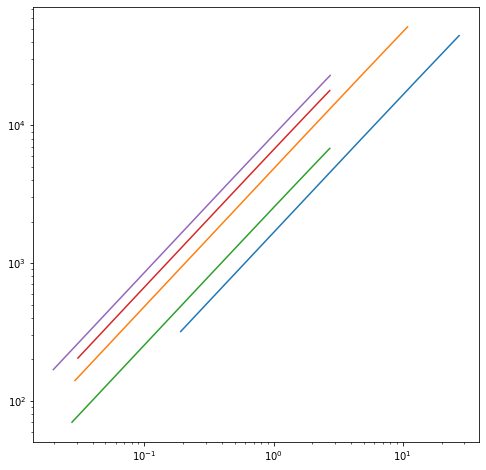

In [86]:
delx = 500
wav = 1.02e-6
plt.figure(figsize = (8,8))

for i in range(len(flows)):
    segments = np.arange(1*delx, flows[i]["length"], delx)
    duration = segments / flows[i]["vel_avg"]
    Tcore = Tlava - segments*flows[i]["dTdx"]
    Tsurf = Tcrust*fcrust + Tcore*(1-fcrust)
    total_power_output = flows[i]["width"]*segments * emis_lava * sigmaB * Tsurf
    thermal_emision = flows[i]["width"] *segments * planck(wav, Tsurf)/1e6
    thermal_emision_excess = flows[i]["width"] *segments * (planck(wav, Tsurf) - planck(wav, Tatm_venus))/1e6
    cum_thermal_emission = np.cumsum(thermal_emision)
    cum_thermal_emission_excess = np.cumsum(thermal_emision_excess)
    
    plt.plot(duration/24/3600, total_power_output)
    
plt.semilogx()
plt.semilogy()
plt.show()

## Computing dt/dx and dt/dt

## flowgo type modeling ##

In [8]:
effusion_rate = 10          ## m3/s

In [6]:
## compute intial conditions ##
Tsurf = Tlava
Tcore = Tlava
eta = eta0
ys = ys0
phi_crystal = phi0_crystal

## Emplacement
wb = flow.levee_width(rho, g, eta, theta_deg, ys, effusion_rate)
wc = flow.channel_width(rho, g, eta, theta_deg, ys, effusion_rate, wb)
h = flow.channel_thickness(rho, g, eta, theta_deg, ys, effusion_rate)
hb = flow.levee_thickness(rho, g, eta, theta_deg, ys, effusion_rate)
vel = flow.velocity_Bingham(rho, g, h, eta, theta_deg, ys)

## surface flux
qflynn = flow.flynn_flux(Tsurf)
qcoupled = flow.coupled_flux(Tsurf, 750, k, 0.95) 
print(vel)

0.11564621286044734


In [ ]:
## Running iterative model ##

## set model parameters
t = 0
dt  = 60
flow_length = 0.0

while (vel>=1e-4) and (Tcore>=Tsolid):
    ## Emplacement
    hb = flow.levee_thickness(rho, g, eta, theta_deg, ys, effusion_rate)
    wb = flow.levee_width(rho, g, eta, theta_deg, ys, effusion_rate)
    wc = flow.channel_width(rho, g, eta, theta_deg, ys, effusion_rate, wb)
    h = flow.channel_thickness(rho, g, eta, theta_deg, ys, effusion_rate)
    l = vel * dt
    
    ## heat loss
    qcoupled = flow.coupled_flux(Tsurf, 750, k, 0.95)  
    Told = Tcore
    
    ## new variables
    # print(qcoupled, l, wc, h, rho, vel)
    print(qcoupled * l / rho / C / vel / h)
    Tcore = Told - qcoupled * l / rho / C / vel / h
    flow_length += l

    print("viscosity = ", eta)
    print("flow length = ", flow_length, "width = ", wc, " height = ", h, " levee width = ", wb )
    eta = flow.viscosity(Tlava, Tcore, phi_crystal, phi_crystal_max, eta0)
    ys = flow.yield_strength(Tlava, Tcore, phi_crystal)
    vel = flow.velocity_Bingham(rho, g, h, eta, theta_deg, ys)
    print("velocity = ", vel)
    t+=dt
    print("Tcore=", Tcore, " velocity = ", vel,"\n")
    

In [ ]:
## comparing coupled heat loss implementations
X = np.arange(1500, 1000, -50)
flynn_2023 = flynn_flux(X) / 1e3
this_study =  coupled_flux(X, 737, k, 0.95) / 1e3
rad = radiative_flux(X, 737, 0.95) / 1e3
conv = convection_flux(X, 737, 0.95) / 1e3
plt.figure(figsize = (8,8))
plt.plot(X, flynn_2023, label = "Flynn et al. 2023")
plt.plot(X, this_study, label = "this study")
plt.plot(X, rad, label = "radiation only")
plt.plot(X, conv, label = "convection only")
plt.plot(X, conv+rad, label = "convection + radiation")
plt.xlabel("Surface temperature K")
plt.ylabel("Surface heat flux kW/m2")
plt.legend()
plt.show()

In [ ]:
## calculation of new variables
eta = viscosity(Tlava, Tcurrent, phi_crystal, phi_crystal_max, eta0)
ys = yield_strength()
vel = velocity_Bingham(rho, g, h, eta, theta_deg, yield_strength)